<center><h1> Working with Metabolomics Data
<center><h6> Aditya Subramanian

**Dataset** : https://www.ebi.ac.uk/metabolights/editor/MTBLS6739/protocols

In [33]:
#fundamental imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#imports for UMAP
import umap
import umap.plot

#imports for ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

#imports for random forest
from sklearn.ensemble import RandomForestClassifier

#imports for lgmb
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

#imports for AUC-ROC curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

%matplotlib inline

In [2]:
#settings
sns.set_theme(style = 'white', context = 'notebook', rc = {'figure.figsize':(14,10)})

In [3]:
#read in csv and set target
df_features = pd.read_csv("../Datasets/m_MTBLS6739_LCxLC-MS_pos_metabolite_profiling_v2_maf.tsv", sep = "\t")

<center><h1> Preprocessing

In [4]:
#remove unnecessary columns from features
df_features = df_features.drop(columns = df_features.columns[5:22])
df_features = df_features.drop(columns = df_features.columns[0:4])

#set target
df_target = df_features.iloc[0]
df_target = df_target.drop(df_target.index[0])

#transpose target
df_target = df_target.transpose()
df_target = df_target.map({'TRUE': 1, 'FALSE': 0})

#remove target from features
df_features = df_features.drop(df_features.index[0])

#transpose and set metabolites to column headers in features
df_features = df_features.transpose()
df_features.columns = df_features.iloc[0]
df_features = df_features.drop(df_features.index[0])

#remove duplicate columns in features
df_features = df_features.loc[:, ~df_features.columns.duplicated()].copy()

#cast objects to float
df_features = df_features.astype(float)
df_target = df_target.astype(float)

In [5]:
df_features.head()

metabolite_identification,Sulfocysteine,Taurine,Pyroglutamic Acid,Aspartic Acid,Hydroxyproline,Asparagine,Serine,Glutamine,Glutamic Acid,Sarcosine,...,Isoleucine,Leucine,Phenylalanine,Tryptophan,Ornithine,1-Methylhistidine,3-Methylhistidine,Histidine,Lysine,Arginine
plasma_crp_01,3.491482,203.599790,192710.4624,98.923870,51.361755,65.156375,357.233820,163.285809,875.795669,7.692426,...,265.713245,445.443710,309.443563,99.463594,232.181430,7.836114,80.653840,142.612945,672.357351,541.822960
plasma_crp_02,5.191624,52.832181,243181.8471,27.061255,12.231066,79.314477,216.649719,402.460486,547.281112,2.351550,...,315.298642,966.908365,287.715350,151.098759,122.992801,4.674881,59.574964,201.485916,625.336070,279.318182
plasma_crp_03,6.011404,77.654592,375235.0718,55.410885,62.166770,115.267721,306.457987,667.746118,1044.014188,6.722756,...,223.639425,533.465153,349.324636,93.289504,206.527753,3.727758,38.688733,225.972085,791.779315,405.244939
plasma_crp_04,7.544113,141.371358,230537.3596,64.640338,12.485969,23.048100,242.713621,188.655351,469.567813,3.736766,...,201.038686,326.701792,362.687686,70.074961,319.025599,1.790194,19.586817,193.779517,714.530556,331.674982
plasma_crp_06,4.803333,221.859500,641169.4088,86.717985,23.572179,65.665907,265.995606,952.744116,584.020957,2.952311,...,249.128080,432.814153,368.453408,79.919892,358.272201,5.334984,41.755196,188.502542,538.924973,276.583654


In [6]:
df_target.head()

plasma_crp_01    0.0
plasma_crp_02    0.0
plasma_crp_03    0.0
plasma_crp_04    0.0
plasma_crp_06    0.0
Name: 0, dtype: float64

<center><h1> UMAP Reduction

In [7]:
#standardize and apply umap
df_standard = StandardScaler().fit_transform(df_features)
reducer = umap.UMAP(n_components = 20, random_state = 4).fit(df_standard)

#store in embedding
embedding = reducer.transform(df_standard)

/opt/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<center><h1> Test ML Models

In [8]:
#split into test and train
X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, test_size = 0.25, random_state = 6)
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(embedding, df_target, test_size = 0.25, random_state = 6)

<center><h3> Random Forest

In [9]:
#fit into decision tree
rf =  RandomForestClassifier(random_state=1)
rf = rf.fit(X_train, y_train)

rf_reduced =  RandomForestClassifier(random_state=1)
rf_reduced = rf_reduced.fit(X_train_reduced, y_train_reduced)

<center><h3> No Dimension Reduction

1.9 ms ± 79 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


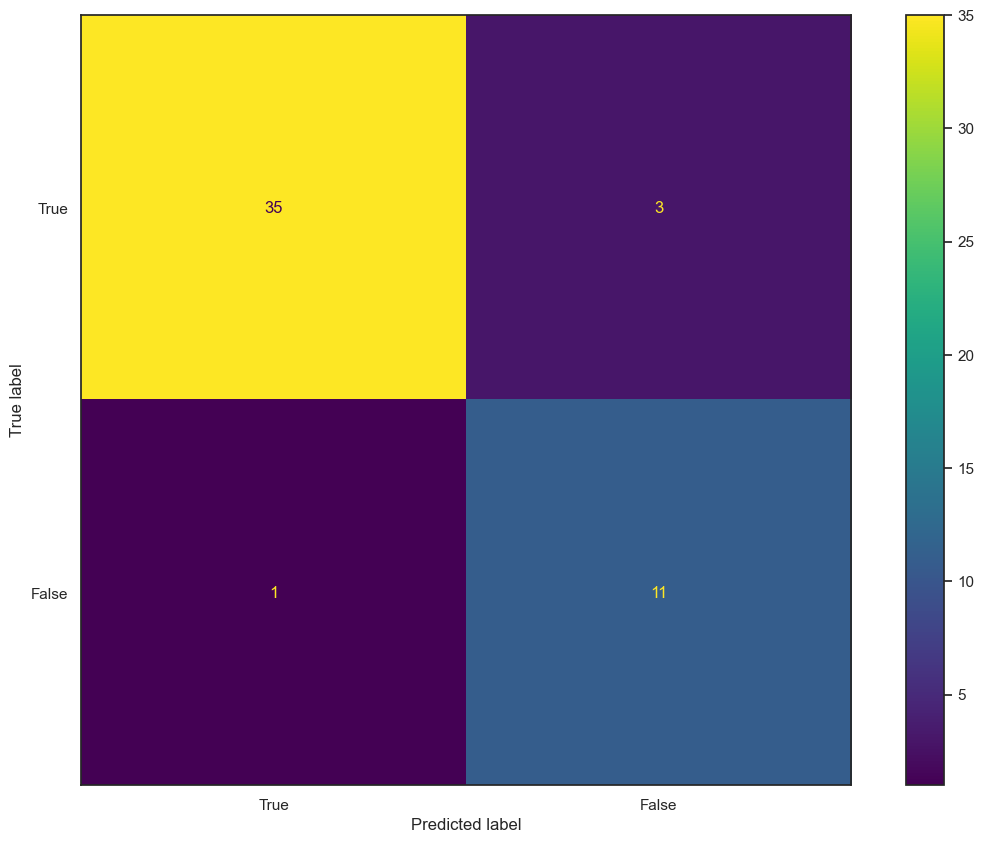

In [13]:
#separate into predicted an actual values to create confusion matrix
%timeit y_predictions_rf = rf.predict(X_test)

confusion_matrix = metrics.confusion_matrix(y_test, y_predictions_rf)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['True', 'False'])

cm_display.plot()
plt.show()

In [14]:
#calculate ml metrics
accuracy_rf = metrics.accuracy_score(y_test, y_predictions_rf)
precision_rf = metrics.precision_score(y_test, y_predictions_rf, average = 'weighted')
recall_rf = metrics.recall_score(y_test, y_predictions_rf, average = 'weighted')
f1_rf = metrics.f1_score(y_test, y_predictions_rf, average = 'weighted')

#print metrics
print({"Accuracy": accuracy_rf,"Precision": precision_rf,"Recall_score": recall_rf, "F1_score": f1_rf})

{'Accuracy': 0.92, 'Precision': 0.9274603174603174, 'Recall_score': 0.92, 'F1_score': 0.921995841995842}


<center><h3> Dimension Reduction

1.58 ms ± 58.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


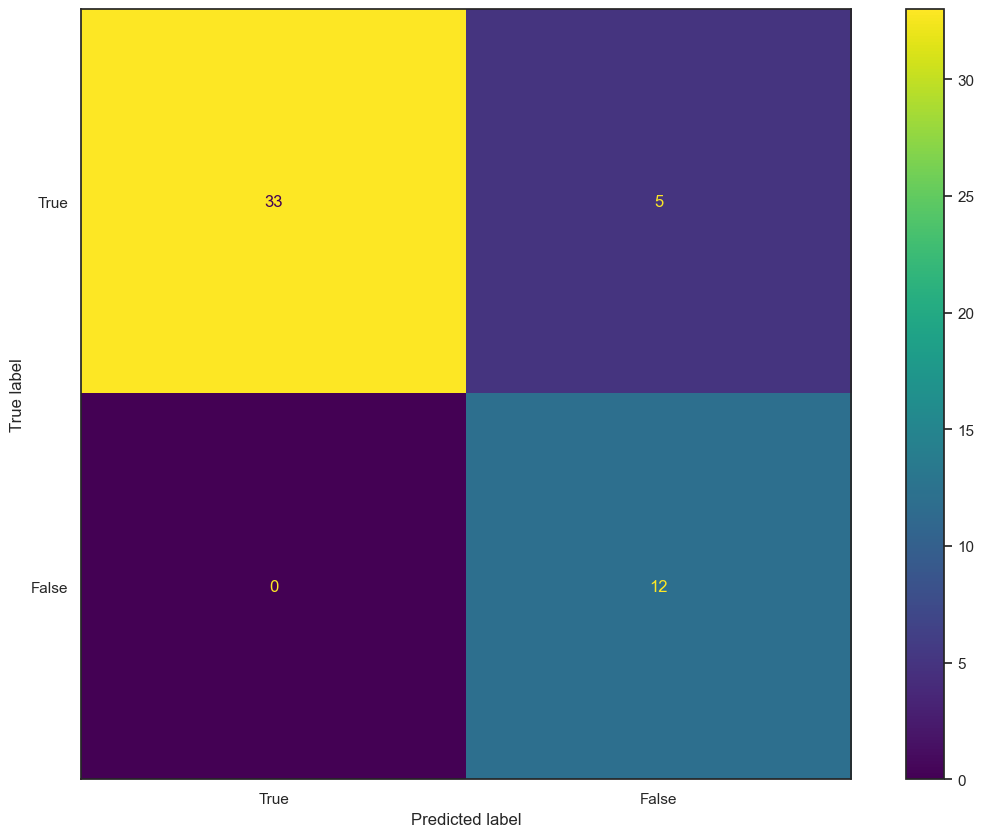

In [17]:
#separate into predicted an actual values to create confusion matrix
%timeit y_predictions_rf_reduced = rf_reduced.predict(X_test_reduced)

confusion_matrix = metrics.confusion_matrix(y_test_reduced, y_predictions_rf_reduced)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['True', 'False'])

cm_display.plot()
plt.show()

In [18]:
#calculate ml metrics
accuracy_rf_reduced = metrics.accuracy_score(y_test_reduced, y_predictions_rf_reduced)
precision_rf_reduced = metrics.precision_score(y_test_reduced, y_predictions_rf_reduced, average = 'weighted')
recall_rf_reduced = metrics.recall_score(y_test_reduced, y_predictions_rf_reduced, average = 'weighted')
f1_rf_reduced = metrics.f1_score(y_test_reduced, y_predictions_rf_reduced, average = 'weighted')

#print metrics
print({"Accuracy": accuracy_rf_reduced,"Precision": precision_rf_reduced,"Recall_score": recall_rf_reduced, "F1_score": f1_rf_reduced})

{'Accuracy': 0.9, 'Precision': 0.9294117647058823, 'Recall_score': 0.9, 'F1_score': 0.905099562894609}


Neither model appears overfit. The model fit with a dimensionally reduced dataset is less accurate(0.9 vs 0.92) and also has more false positives(5 vs 3). However, it is faster as it runs in 1.56 vs 1.78. Considering their similar accuracy and false positive rate, the UMAP dimension reduction appears effective despite its faster runtime.

<center><h3> LGBM

In [19]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [20]:
#fit into lgbm model
lgbm = lgb.LGBMClassifier(random_state = 1)
lgbm = lgbm.fit(X_train, y_train)

lgbm_reduced = lgb.LGBMClassifier(random_state = 1)
lgbm_reduced = lgbm_reduced.fit(X_train_reduced, y_train_reduced)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 58, number of negative: 92
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1866
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.386667 -> initscore=-0.461346
[LightGBM] [Info] Start training from score -0.461346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

<center><h3> No Dimension Reduction

354 µs ± 11.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


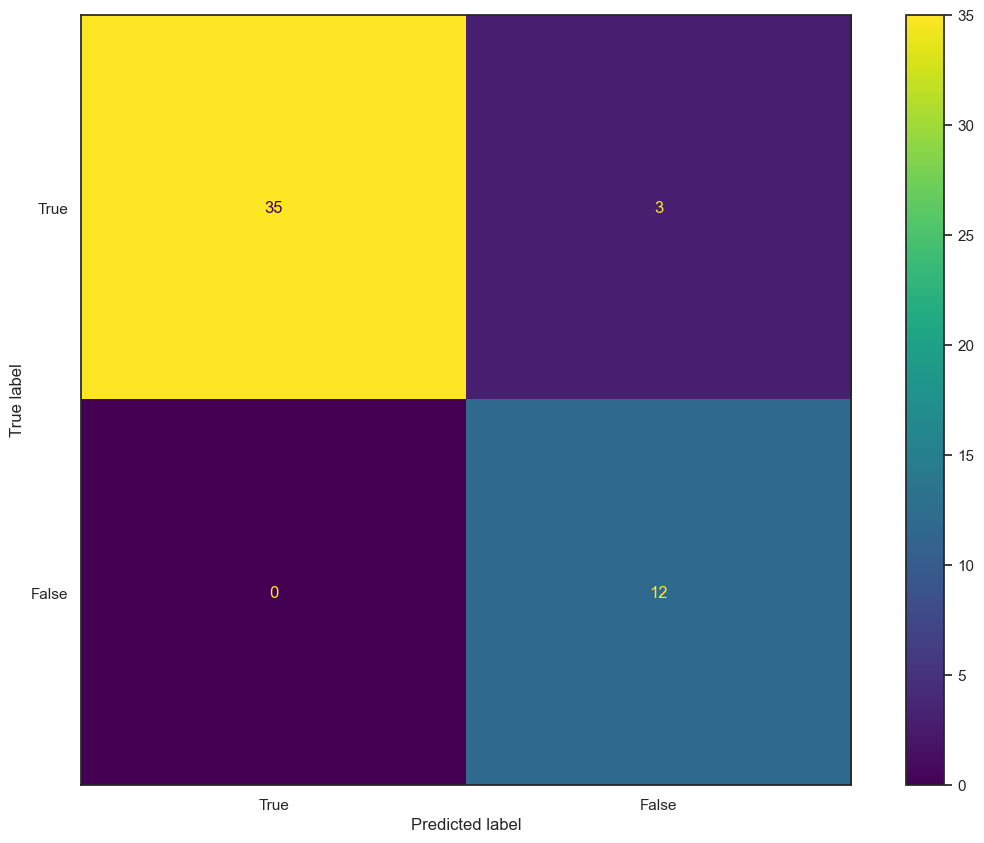

In [23]:
#separate into predicted an actual values to create confusion matrix
%timeit y_predictions_lgbm = lgbm.predict(X_test)

confusion_matrix = metrics.confusion_matrix(y_test, y_predictions_lgbm)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['True', 'False'])

cm_display.plot()
plt.show()

In [27]:
#calculate ml metrics
accuracy_lgbm = metrics.accuracy_score(y_test, y_predictions_lgbm)
precision_lgbm = metrics.precision_score(y_test, y_predictions_lgbm, average = 'weighted')
recall_lgbm = metrics.recall_score(y_test, y_predictions_lgbm, average = 'weighted')
f1_lgbm = metrics.f1_score(y_test, y_predictions_lgbm, average = 'weighted')

#print metrics
print({"Accuracy": accuracy_lgbm,"Precision": precision_lgbm,"Recall_score": recall_lgbm, "F1_score": f1_lgbm})

{'Accuracy': 0.94, 'Precision': 0.9520000000000001, 'Recall_score': 0.94, 'F1_score': 0.9421004566210044}


245 µs ± 7.77 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


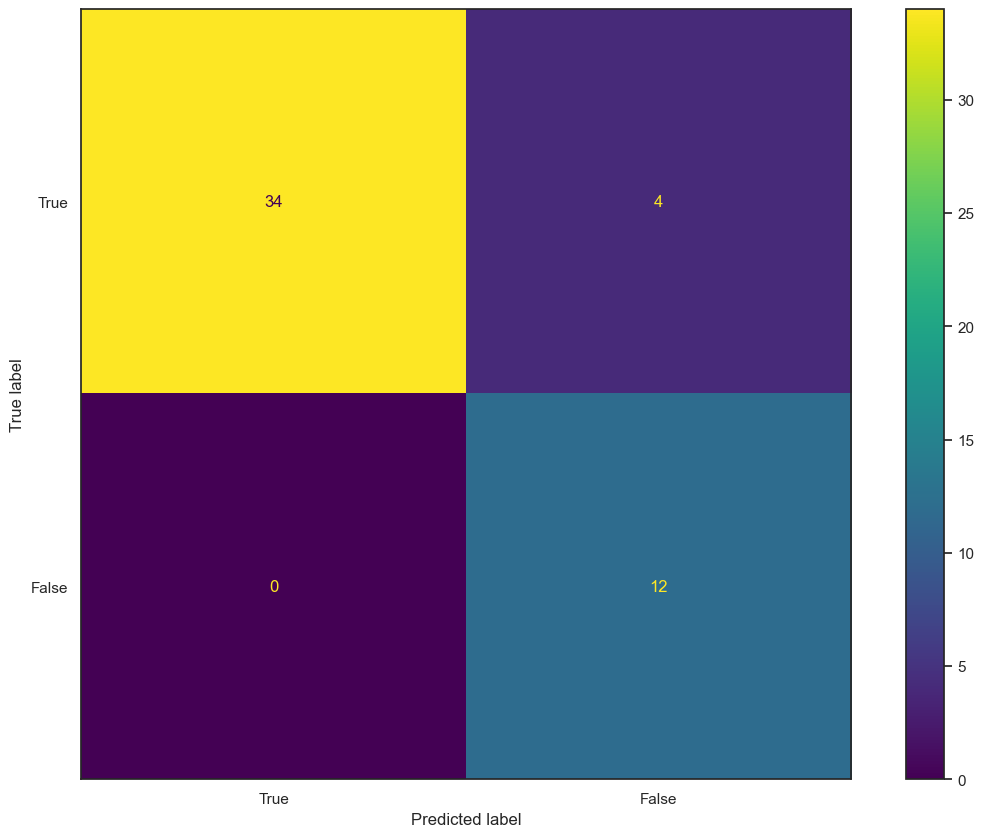

In [30]:
#separate into predicted an actual values to create confusion matrix
%timeit y_predictions_lgbm_reduced = lgbm_reduced.predict(X_test_reduced)

confusion_matrix = metrics.confusion_matrix(y_test, y_predictions_lgbm_reduced)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['True', 'False'])

cm_display.plot()
plt.show()

Neither model appears overfit. The model fit with a dimensionally reduced dataset is less accurate(0.9 vs 0.92) and also has more false positives(5 vs 3). However, it is faster as it runs in 1.56 vs 1.78. Considering their similar accuracy and false positive rate, the UMAP dimension reduction appears effective despite its faster runtime.

In [32]:
#calculate ml metrics
accuracy_lgbm_reduced = metrics.accuracy_score(y_test_reduced, y_predictions_lgbm_reduced)
precision_lgbm_reduced = metrics.precision_score(y_test_reduced, y_predictions_lgbm_reduced, average = 'weighted')
recall_lgbm_reduced = metrics.recall_score(y_test_reduced, y_predictions_lgbm_reduced, average = 'weighted')
f1_lgbm_reduced = metrics.f1_score(y_test_reduced, y_predictions_lgbm_reduced, average = 'weighted')

#print metrics
print({"Accuracy": accuracy_lgbm_reduced,"Precision": precision_lgbm_reduced,"Recall_score": recall_lgbm_reduced, "F1_score": f1_lgbm_reduced})

{'Accuracy': 0.92, 'Precision': 0.94, 'Recall_score': 0.92, 'F1_score': 0.9234920634920634}


In [55]:
##Calculate roc auc

#random forest roc auc
rf_roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])

#random forest with reduced dataset roc auc
rf_reduced_roc_auc = roc_auc_score(y_test_reduced, rf_reduced.predict_proba(X_test_reduced)[:, 1])
fpr_rf_reduced, tpr_rf_reduced, thresholds_rf_reduced = roc_curve(y_test, rf_reduced.predict_proba(X_test_reduced)[:, 1])

#lgbm roc auc
lgbm_roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test)[:, 1])
fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(y_test, lgbm.predict_proba(X_test)[:, 1])

#lgbm with reduced dataset roc auc
lgbm_reduced_roc_auc = roc_auc_score(y_test_reduced, lgbm_reduced.predict_proba(X_test_reduced)[:, 1])
fpr_lgbm_reduced, tpr_lgbm_reduced, thresholds_lgbm_reduced = roc_curve(y_test, lgbm_reduced.predict_proba(X_test_reduced)[:, 1])

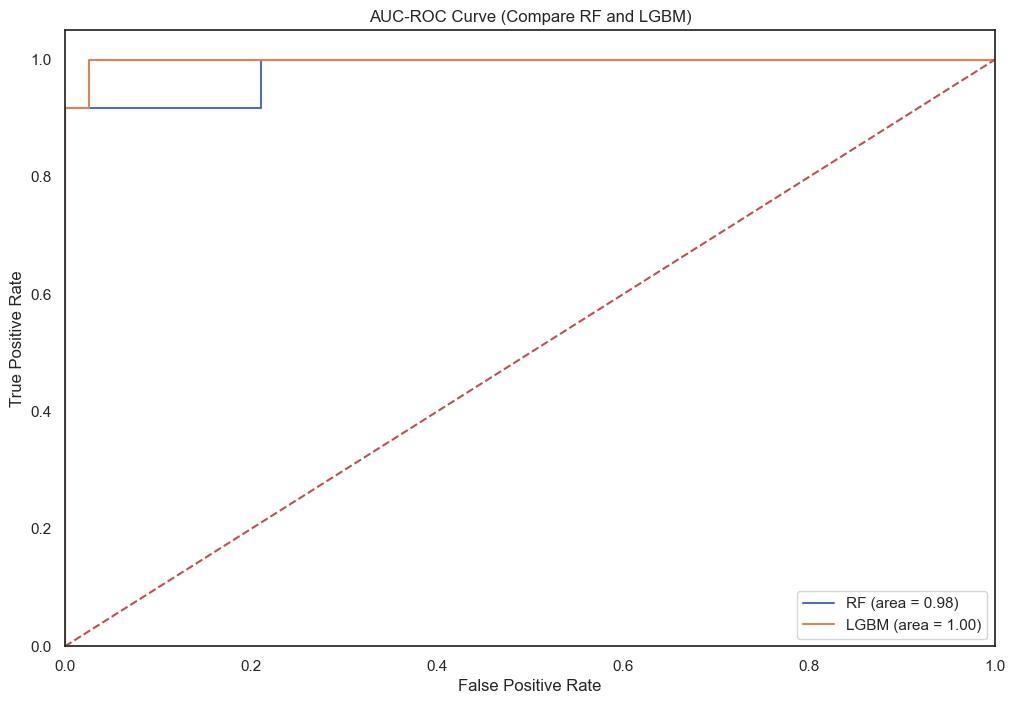

In [62]:
#figure size
plt.figure(figsize=(12,8))

#add random forest
plt.plot(fpr_rf, tpr_rf, label='RF (area = %0.2f)' % rf_roc_auc)

#add lgbm
plt.plot(fpr_lgbm, tpr_lgbm, label='LGBM (area = %0.2f)' % lgbm_roc_auc)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve (Compare RF and LGBM)')
plt.legend(loc="lower right")
plt.savefig('AUC-ROC')
plt.show()

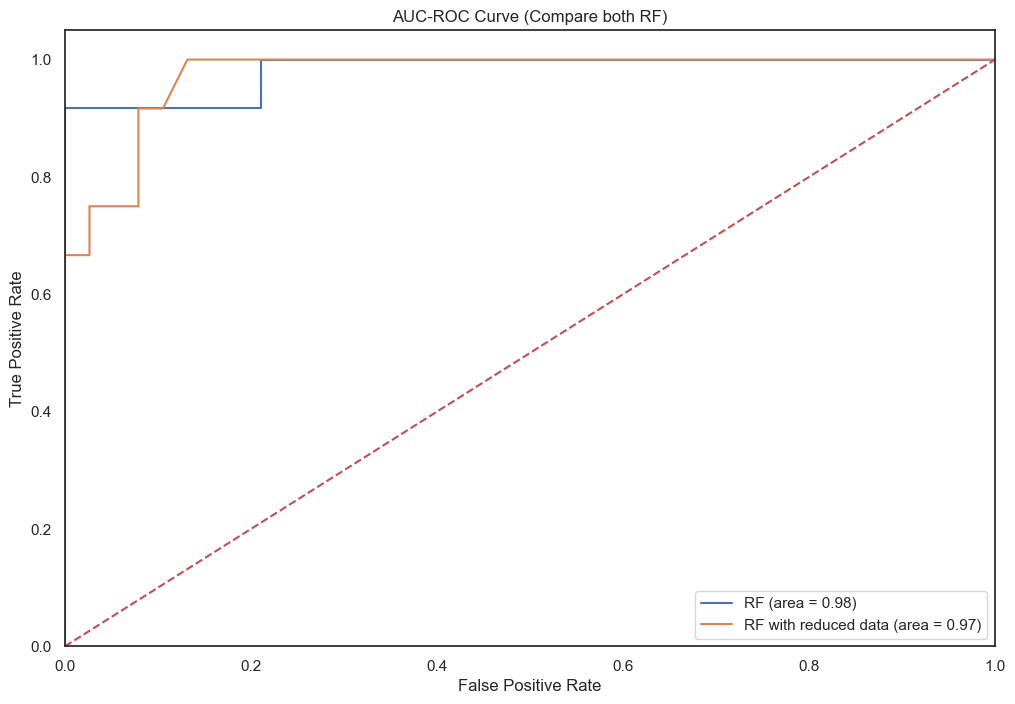

In [63]:
#figure size
plt.figure(figsize=(12,8))

#add random forest
plt.plot(fpr_rf, tpr_rf, label='RF (area = %0.2f)' % rf_roc_auc)
plt.plot(fpr_rf_reduced, tpr_rf_reduced, label='RF with reduced data (area = %0.2f)' % rf_reduced_roc_auc)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve (Compare both RF)')
plt.legend(loc="lower right")
plt.savefig('AUC-ROC-2')
plt.show()

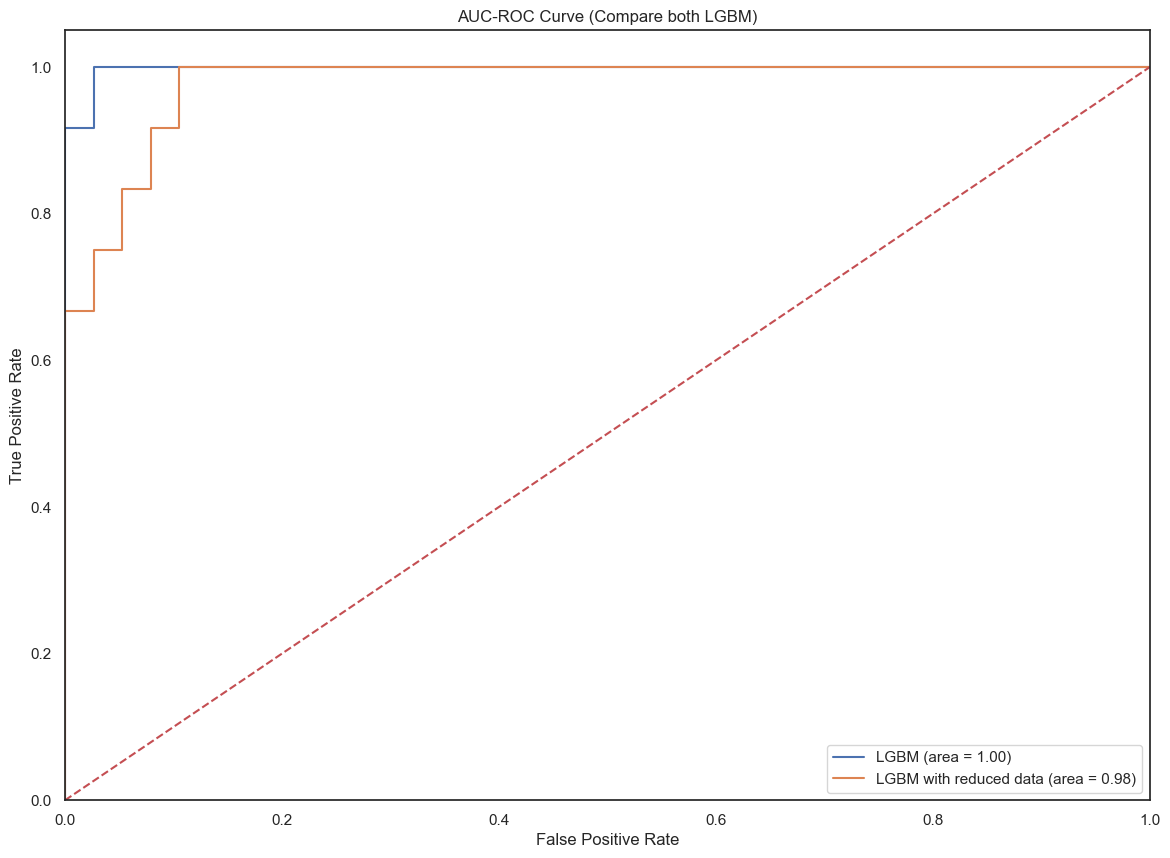

In [64]:
#add lgbm
plt.plot(fpr_lgbm, tpr_lgbm, label='LGBM (area = %0.2f)' % lgbm_roc_auc)
plt.plot(fpr_lgbm_reduced, tpr_lgbm_reduced, label='LGBM with reduced data (area = %0.2f)' % lgbm_reduced_roc_auc)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve (Compare both LGBM)')
plt.legend(loc="lower right")
plt.savefig('AUC-ROC')
plt.show()

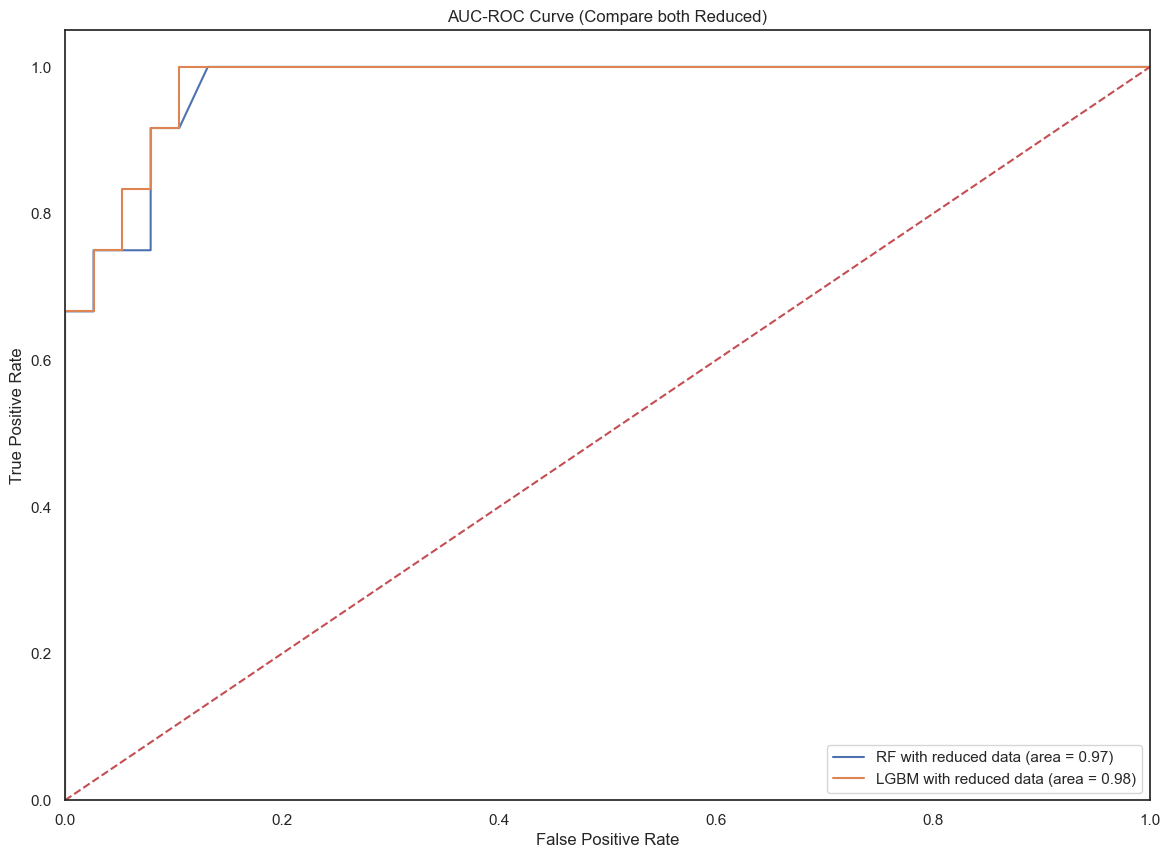

In [65]:
#add lgbm
plt.plot(fpr_rf_reduced, tpr_rf_reduced, label='RF with reduced data (area = %0.2f)' % rf_reduced_roc_auc)
plt.plot(fpr_lgbm_reduced, tpr_lgbm_reduced, label='LGBM with reduced data (area = %0.2f)' % lgbm_reduced_roc_auc)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve (Compare both Reduced)')
plt.legend(loc="lower right")
plt.savefig('AUC-ROC')
plt.show()